In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score

In [2]:
data=pd.read_excel('Flight_Fare.xlsx')
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


## When we have done basic check about columns, there are 4 features that will not be contributing to our price. Below we will explain why they are not required

### Date_of_Journey - This feature only contributes if they would have also given the ticket booking date.

### Route - This feature tells how many stops the aeroplane is making inbetween Source and Destination which is already given as another column (Total_Stops).

### Dep_Time and Arrival_Time - The difference between these columns is nothing, but Duration column

## Exploratory Data Analysis

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


## There is only 1 missing value in Route and Total_Stops feature, so we can either replace it with the maximum occuring value(Mode) or remove it from the dataset.

In [4]:
data.loc[data.Route.isnull(),:]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


In [5]:
data.loc[(data.Source=='Delhi') & (data.Destination=='Cochin') & (data.Airline=='Air India') & (data.Price>7000) & (data.Price<8000),:].Total_Stops.value_counts()

Total_Stops
1 stop      72
non-stop     4
2 stops      4
Name: count, dtype: int64

In [6]:
data.Total_Stops.mode()

0    1 stop
Name: Total_Stops, dtype: object

In [7]:
data.loc[data.Route.isnull(),'Total_Stops']='1 stop'

## Changing the column datatype to numerical

In [8]:
var=data.Duration
def func(arg):
    if 'm' not in arg:
        return int(arg.replace('h',''))
    elif 'h' not in arg:
        return round(int(arg.replace('m',''))/60,3)
    else:
        temp=arg.replace('h','').replace('m','').split(' ')
        return round(int(temp[0])+int(temp[1])/60,3)
data.Duration=var.apply(func)

In [9]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2.833,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7.417,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19.000,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5.417,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4.750,1 stop,No info,13302


In [13]:
data.Additional_Info.unique()

array(['No info', 'In-flight meal not included',
       'No check-in baggage included', '1 Short layover',
       '1 Long layover', 'Change airports', 'Business class',
       'Red-eye flight', '2 Long layover'], dtype=object)

In [11]:
data.Additional_Info.value_counts()

Additional_Info
No info                         8345
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: count, dtype: int64

In [12]:
data.replace('No Info','No info',inplace=True)

In [14]:
data.Source.unique()

array(['Banglore', 'Kolkata', 'Delhi', 'Chennai', 'Mumbai'], dtype=object)

In [19]:
data.Destination.unique()

array(['Delhi', 'Banglore', 'Cochin', 'Kolkata', 'Hyderabad'],
      dtype=object)

In [18]:
data.replace('New Delhi','Delhi',inplace=True)

In [23]:
temp_df1=pd.get_dummies(data.Airline,prefix='Airline',dtype=int,drop_first=True)
temp_df2=pd.get_dummies(data.Source,prefix='Source',dtype=int,drop_first=True)
temp_df3=pd.get_dummies(data.Destination,prefix='Destination',dtype=int,drop_first=True)
temp_df4=pd.get_dummies(data.Total_Stops,prefix='Total_Stops',dtype=int,drop_first=True)
temp_df5=pd.get_dummies(data.Additional_Info,prefix='Additional_Info',dtype=int,drop_first=True)

In [25]:
X=pd.concat([temp_df1,temp_df2,temp_df3,temp_df4,temp_df5,data.Duration],axis=1)
y=data.Price

In [36]:
X.shape,y.shape

((10683, 32), (10683,))

## Performing feature engineering

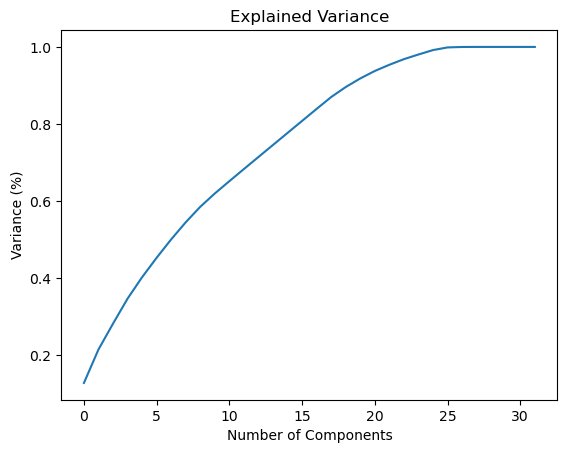

In [28]:
scaled_data=StandardScaler().fit_transform(X)
pca = PCA()
pca.fit_transform(pd.DataFrame(data=scaled_data, columns= X.columns))
plt.figure()
variance_change=np.cumsum(pca.explained_variance_ratio_)
plt.plot(variance_change)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

In [32]:
len(np.where(variance_change<0.9)[0])

19

## Since 19 features are capturing the total variance of data, we can create a new dataset with these many principle components 

In [34]:
pca=PCA(n_components=19)
new_X=pd.DataFrame(pca.fit_transform(X),columns=['Principle_comp_'+str(i) for i in range(1,20)])
new_X

,Principle_comp_1,Principle_comp_2,Principle_comp_3,Principle_comp_4,Principle_comp_5,Principle_comp_6,Principle_comp_7,Principle_comp_8,Principle_comp_9,Principle_comp_10,Principle_comp_11,Principle_comp_12,Principle_comp_13,Principle_comp_14,Principle_comp_15,Principle_comp_16,Principle_comp_17,Principle_comp_18,Principle_comp_19
0,-7.947581,0.373171,-0.501452,0.665380,-0.657942,0.219975,-0.231671,-0.184565,-0.112383,-0.174751,0.096043,0.057419,-0.119368,-0.019856,-0.031504,-0.011276,-0.001358,-0.005206,0.002265
1,-3.268073,0.438061,-0.675354,-0.625813,0.713979,-0.425473,0.298649,-0.938271,-0.070996,-0.094714,0.445716,-0.224511,0.114279,-0.037738,-0.011135,-0.021060,0.013620,-0.008644,0.002747
2,8.328245,-0.638236,0.175262,0.209271,-0.039057,0.069376,0.667765,-0.163142,0.599033,-0.174432,0.284677,0.043859,0.022835,-0.037263,0.019065,-0.003609,0.014201,0.002529,-0.000056
3,-5.311434,0.405928,-0.455376,-0.907328,-0.560264,0.221203,-0.067948,-0.353350,-0.227634,-0.192468,0.075113,-0.297560,0.093821,-0.024650,-0.003945,-0.012419,0.006005,-0.003954,0.000182
4,-5.996517,0.218263,-0.422668,0.375590,-0.810379,-0.034351,-0.138582,-0.263390,-0.367273,-0.281547,0.083706,-0.635510,0.187241,-0.016432,-0.041868,0.002439,0.003164,-0.019029,-0.004613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,-8.244676,0.570330,-0.330801,-0.611271,0.128914,-0.165186,0.020936,-0.035716,0.146928,0.044375,0.051935,0.519763,-0.107180,0.105841,0.078336,0.318867,0.019773,0.000081,-0.045414
10679,-8.150404,0.579188,-0.609657,-0.502403,0.632170,-0.291231,0.037734,-0.507080,-0.135432,0.286915,-0.219001,0.453149,-0.284183,-0.072459,-0.003936,-0.035550,-0.015608,0.006435,0.006780
10680,-7.747517,0.575697,0.222420,0.755361,-0.305298,-0.446888,0.516728,0.053370,0.229847,0.068795,-0.034184,0.184236,-0.238091,-0.088847,-0.008155,-0.018926,0.003625,-0.001357,0.003958
10681,-8.097750,0.437364,-0.368142,0.701729,-0.158763,-0.465548,-0.106958,0.204050,0.029674,0.078968,0.080522,0.497157,0.773350,-0.153021,-0.079087,-0.041603,0.006440,-0.002558,0.002784


## Splitting the dataset into training and testing dataset

In [79]:
X_train,X_test,y_train,y_test=train_test_split(new_X,y,test_size=0.2)

## Training different ML models with the Training data and calculating the r2 score

In [80]:
model1=LinearRegression()
model1.fit(X_train,y_train)
y_pred1=model1.predict(X_test)
r2_score(y_test,y_pred1)

0.63210389178576

In [81]:
model2=SVR()
model2.fit(X_train,y_train)
y_pred2=model2.predict(X_test)
r2_score(y_test,y_pred2)

0.19532671604196472

In [82]:
model3=DecisionTreeRegressor()
model3.fit(X_train,y_train)
y_pred3=model3.predict(X_test)
r2_score(y_test,y_pred3)

0.6505454734676259

In [83]:
model4=RandomForestRegressor()
model4.fit(X_train,y_train)
y_pred4=model4.predict(X_test)
r2_score(y_test,y_pred4)

0.6888195286511194

In [84]:
model5=BaggingRegressor()
model5.fit(X_train,y_train)
y_pred5=model5.predict(X_test)
r2_score(y_test,y_pred5)

0.6904577384615767

In [85]:
model6=GradientBoostingRegressor()
model6.fit(X_train,y_train)
y_pred6=model6.predict(X_test)
r2_score(y_test,y_pred6)

0.7437722553556491

In [86]:
model7=XGBRegressor()
model7.fit(X_train,y_train)
y_pred7=model7.predict(X_test)
r2_score(y_test,y_pred7)

0.6888309875325884

# The Maximum Accuracy that we can get from the models is 74%, so we can conclude that GradientBoosting is the best model to deploy in production